# FORCE 2020 LITHOLOGY CLASSIFICATION COMPETITION
WELL - input well 
DEPTH_MD - non-corrected measured depth 
FORCE_2020_LITHOFACIES_LITHOLOGY - input lithology assumed to reflect the GeoScout mudrock interpretation  
FORCE_2020_LITHOFACIES_CONFIDENCE - uncertainty placed on the mudrock interpretation  

CALI - borehole measurement expect to be directly related to BS  
BS - borehole size  
GR - predominately correlates with lithology, minor linear relationship with depth  

DTC - 304804/x gives velocity in m/s, expect to have linear relationship with depth below mudline  
DTS - 304804/x gives velocity which should have a linear relationship with Vp  
NPHI - neutron porosity has a strong lithology correlation, bound water in shales results with high apparent porosity  
RHOB - density measurement, requires good contact with well edge meaning values can be bad when CALI-BS is large  

DRHO - Matrix density using for conversion from density porosity to density.  
RSHA - strongly affected by mud size and salinity  
RMED - logorithmic relationship with lithology and porosity, affected by mud contrast with formation salinity  
RDEP - similar to RMED, RDEP-RMED useful indication of hydrocarbons  

SP - relationship with pore fluids and mud salinity but also affected by lithology and hole condition  
PEF - relationship with lithology but also mud/wellbore condition  
ROP - penetration rate, correlation to formation hardness (density & porosity) and bit wear (linear with time)

Group - corresponds to a general age  
Formation - corresponds to lithology and a more specific age than group  
Mudweight - correlation with depth and formation pressure  
X_LOC, Y_LOC - spacial location can be used to generate 3D distribution of age with depth.
Z_LOC - the TVD below either the KB or the SL.

DCAL, SGR - Logs used as part of creating other logs  
RMIC, ROPA, RXO - Logs that contain drilling engineering information  

[Wikipedia](https://en.wikipedia.org/wiki/Petrophysics) description of petrophysics   
Canadian Well Logging Society [CWLS](https://www.spwla.org/SPWLA/Technical/Software/CANADIAN_WELL_LOGGING_SOCIETY.aspx)  
[CRAIN] (https://www.spec2000.net/index.htm) good resource for log properties  

## 3. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lasio as ls
from welly import Project, Well

from pandas_profiling import ProfileReport
import ipywidgets as widgets
import missingno as msno

from xgboost import XGBClassifier, plot_importance, plot_tree
from matplotlib.pyplot import rcParams

## 4. Exploratory Data Analysis

### Open and review LAS files

In [2]:
# Open the LAS file
data_7 = ls.read(r'D:\Datasets\las_files_Lithostrat_data\7_1-1.las')

In [3]:
# Get the data sections
data_7.sections.keys()

dict_keys(['Version', 'Well', 'Curves', 'Parameter', 'Other'])

In [4]:
# Get the data from the section
for i in data_7.sections['Well']:
    print(f'{i.descr} ({i.mnemonic}): {i.value}')

 (STRT): 82.600799561
 (STOP): 2815.7912598
 (STEP): 0.152
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): 7/1-1
FIELD (FLD): 
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2020-08-09 20:02:09   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): 7/1-1
API NUMBER (API): 


In [5]:
# Get the data from the curves
for count, c in enumerate(data_7.curves):
    print(f'{c.descr}, ({c.mnemonic})')
print(f'Curves: {count+1}')

DEPTH, (DEPT)
FORCE_2020_LITHOFACIES_CONFIDENCE, (FORCE_2020_LITHOFACIES_CONFIDENCE)
FORCE_2020_LITHOFACIES_LITHOLOGY, (FORCE_2020_LITHOFACIES_LITHOLOGY)
CALI, (CALI)
BS, (BS)
DCAL, (DCAL)
MUDWEIGHT, (MUDWEIGHT)
ROP, (ROP)
RDEP, (RDEP)
RSHA, (RSHA)
RMED, (RMED)
SP, (SP)
DTC, (DTC)
NPHI, (NPHI)
GR, (GR)
RHOB, (RHOB)
DRHO, (DRHO)
DEPTH_MD, (DEPTH_MD)
x_loc, (X_LOC)
y_loc, (Y_LOC)
z_loc, (Z_LOC)
Curves: 21


In [6]:
# Transform the data to a dataframe
well_7 = data_7.df()
well_7.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 17982 entries, 82.600799561 to 2815.7127996
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FORCE_2020_LITHOFACIES_CONFIDENCE  16241 non-null  float64
 1   FORCE_2020_LITHOFACIES_LITHOLOGY   16242 non-null  float64
 2   CALI                               16270 non-null  float64
 3   BS                                 17947 non-null  float64
 4   DCAL                               16272 non-null  float64
 5   MUDWEIGHT                          15724 non-null  float64
 6   ROP                                17343 non-null  float64
 7   RDEP                               16121 non-null  float64
 8   RSHA                               16115 non-null  float64
 9   RMED                               16152 non-null  float64
 10  SP                                 16151 non-null  float64
 11  DTC                               

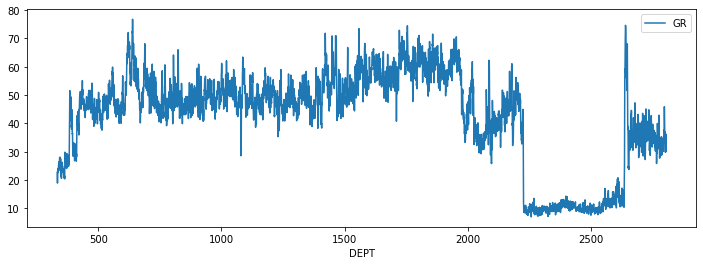

In [7]:
# Plot the data for instance Gamma Ray
well_7.plot(y='GR', figsize=(12, 4));

### Explore all LAS data files using WELLY

In [8]:
# Open all files from a folder
wells = Project.from_las('D:\Datasets\las_files_Lithostrat_data\*.las', index=0)

118it [05:43,  2.91s/it]


In [9]:
# Covert the data to a dataframe
wells_df = wells.df()
wells_df.shape

(1580837, 26)

In [10]:
# Explore the data
wells_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1580837 entries, ('15/9-13', 25.0) to ('7/1-2 S', 3174.936400000855)
Data columns (total 26 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   FORCE_2020_LITHOFACIES_CONFIDENCE  972051 non-null   float64
 1   FORCE_2020_LITHOFACIES_LITHOLOGY   962396 non-null   float64
 2   CALI                               992628 non-null   float64
 3   MUDWEIGHT                          272280 non-null   float64
 4   ROP                                806328 non-null   float64
 5   RDEP                               1518996 non-null  float64
 6   RSHA                               560519 non-null   float64
 7   RMED                               1413566 non-null  float64
 8   RXO                                263411 non-null   float64
 9   SP                                 853321 non-null   float64
 10  DTC                                1215227 non-null

In [11]:
# Target variable can't be NaN, so we need to drop the rows with NaN
wells_df.dropna(subset=['FORCE_2020_LITHOFACIES_LITHOLOGY'], inplace=True)

<AxesSubplot:>

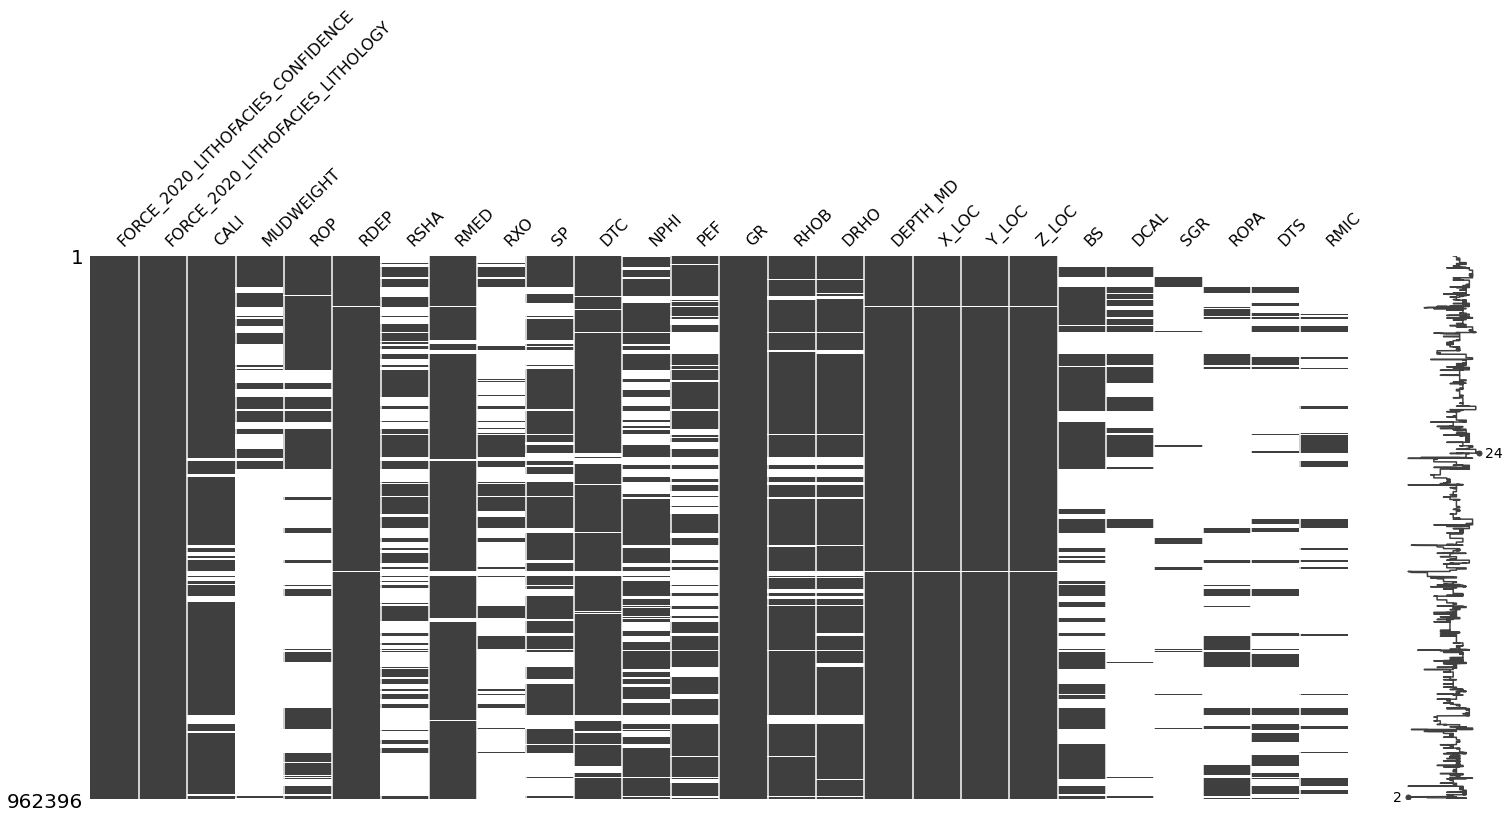

In [12]:
# Plot missing values of the data
msno.matrix(wells_df)

### Explore data given for the competition

In [13]:
# Read data from the directory
data = pd.read_csv('D:\Datasets\Force2020trainingData.csv', delimiter=';')
data.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.5018311,NORDLAND GP.,NaN,19.480834961,NaN,1.6114097834,...,34.636409760,NaN,NaN,-0.574927628,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.6538086,NORDLAND GP.,NaN,19.468799591,NaN,1.6180702448,...,34.636409760,NaN,NaN,-0.570188403,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.8057861,NORDLAND GP.,NaN,19.468799591,NaN,1.6264585257,...,34.779556274,NaN,NaN,-0.574245155,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.9577942,NORDLAND GP.,NaN,19.459281921,NaN,1.6215940714,...,39.965164185,NaN,NaN,-0.586315274,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.1097717,NORDLAND GP.,NaN,19.453100204,NaN,1.6026790142,...,57.483764648,NaN,NaN,-0.597913623,NaN,NaN,NaN,NaN,65000,1.0


In [14]:
# Create a report of the data
report = ProfileReport(data)
# report

In [15]:
data.isnull().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

In [16]:
data_h_t = pd.read_csv('D:\Datasets\hidden_test.csv', delimiter=';')
data_t_f = pd.read_csv('D:\Datasets\leaderboard_test_features.csv', delimiter=';')
data_t_t = pd.read_csv('D:\Datasets\leaderboard_test_target.csv', delimiter=';')

In [17]:
# Check shape of the datasets
data.shape, data_h_t.shape, data_t_f.shape, data_t_t.shape

((1170511, 29), (122397, 29), (136786, 27), (136786, 3))

In [18]:
# Test_features dataset has no target features, so this will be the validation dataset 
data.columns[~data.columns.isin(data_t_f.columns)]

Index(['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'], dtype='object')

In [19]:
# Label data with labels provided by competition
labels = ['Shale', 'Sandstone', 'SS-SH', 'Limestone', 'Marl', 'Tuff', 'Chalk', 'Halite', 'Coal', 'Dolomite', 'Anhydrite', 'Basement']
litho_n = {(data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())[i]:labels[i] for i in range(len(data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()))}
data['LITHO_NAMES'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(litho_n)

In [20]:
# Create a new column with lithology number
litho_num = {sorted(data['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique())[i]:i for i in range(len(data['LITHO_NAMES'].unique()))}
data['LITHO_NUM'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(litho_num)
data.head()

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,LITHO_NAMES,LITHO_NUM
0,15/9-13,494.528,437641.96875,6470972.5,-469.5018311,NORDLAND GP.,NaN,19.480834961,NaN,1.6114097834,...,NaN,-0.574927628,NaN,NaN,NaN,NaN,65000,1.0,Shale,1
1,15/9-13,494.680,437641.96875,6470972.5,-469.6538086,NORDLAND GP.,NaN,19.468799591,NaN,1.6180702448,...,NaN,-0.570188403,NaN,NaN,NaN,NaN,65000,1.0,Shale,1
2,15/9-13,494.832,437641.96875,6470972.5,-469.8057861,NORDLAND GP.,NaN,19.468799591,NaN,1.6264585257,...,NaN,-0.574245155,NaN,NaN,NaN,NaN,65000,1.0,Shale,1
3,15/9-13,494.984,437641.96875,6470972.5,-469.9577942,NORDLAND GP.,NaN,19.459281921,NaN,1.6215940714,...,NaN,-0.586315274,NaN,NaN,NaN,NaN,65000,1.0,Shale,1
4,15/9-13,495.136,437641.96875,6470972.5,-470.1097717,NORDLAND GP.,NaN,19.453100204,NaN,1.6026790142,...,NaN,-0.597913623,NaN,NaN,NaN,NaN,65000,1.0,Shale,1


In [21]:
data.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

In [22]:
data.rename(columns={'FORCE_2020_LITHOFACIES_CONFIDENCE':'CONFIDENCE'}, inplace=True)

In [23]:
data['LITHO_NUM'].value_counts()

1     720803
0     168937
2     150455
3      56320
6      33329
11     15245
4      10513
8       8213
9       3820
5       1688
7       1085
10       103
Name: LITHO_NUM, dtype: int64

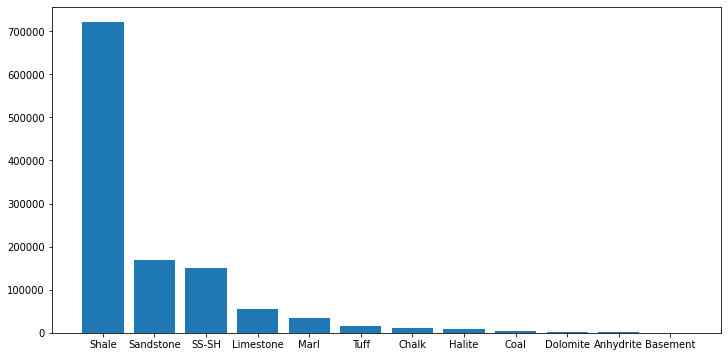

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(data.LITHO_NAMES.unique(), height=data.LITHO_NAMES.value_counts());

In [25]:
data.dtypes

WELL            object
DEPTH_MD       float64
X_LOC          float64
Y_LOC          float64
Z_LOC          float64
GROUP           object
FORMATION       object
CALI           float64
RSHA           float64
RMED           float64
RDEP           float64
RHOB           float64
GR             float64
SGR            float64
NPHI           float64
PEF            float64
DTC            float64
SP             float64
BS             float64
ROP            float64
DTS            float64
DCAL           float64
DRHO           float64
MUDWEIGHT      float64
RMIC           float64
ROPA           float64
RXO            float64
CONFIDENCE     float64
LITHO_NAMES     object
LITHO_NUM        int64
dtype: object

## 5. Building a model

### Baseline model
The model will leave out categorical features and wll not fill null values.

#### Splitting data into train and validation sets. 

In [26]:
# Defining X and Y train datasets
X_train_b = data.drop(['LITHO_NAMES','WELL', 'LITHO_NUM', 'CONFIDENCE','FORMATION','GROUP'], axis=1)
Y_train_b = data['LITHO_NUM']

In [27]:
# Training baseline model
baseline_model = XGBClassifier(n_estimators=20, learning_rate=1, max_depth=3, seed=82).fit(X_train_b, Y_train_b)

In [129]:
# Predicting on the train dataset
Y_train_b_pred = baseline_model.predict(X_train_b)

In [127]:
# Loading penalty matrix used for scoring
A = np.load('D:\Datasets\penalty_matrix.npy')
A[2,2] # Same values won't reduce the score

0.0

In [137]:
# Score the model
def score_model(Y_true, Y_pred):
    S = 0.0
    Y_true = Y_true.astype(int)
    Y_pred = Y_pred.astype(int)
    for i in range(len(Y_true)):
        S -= A[Y_true[i], Y_pred[i]]
    return S/Y_true.shape[0]

In [138]:
score =  score_model(data['LITHO_NUM'], Y_train_b_pred)
print("Contest metric:", round(1 + score/2, 2),"(",round(score,2),")")

Contest metric: 0.42 ( -1.16 )


#### Evaluating features to improve the model

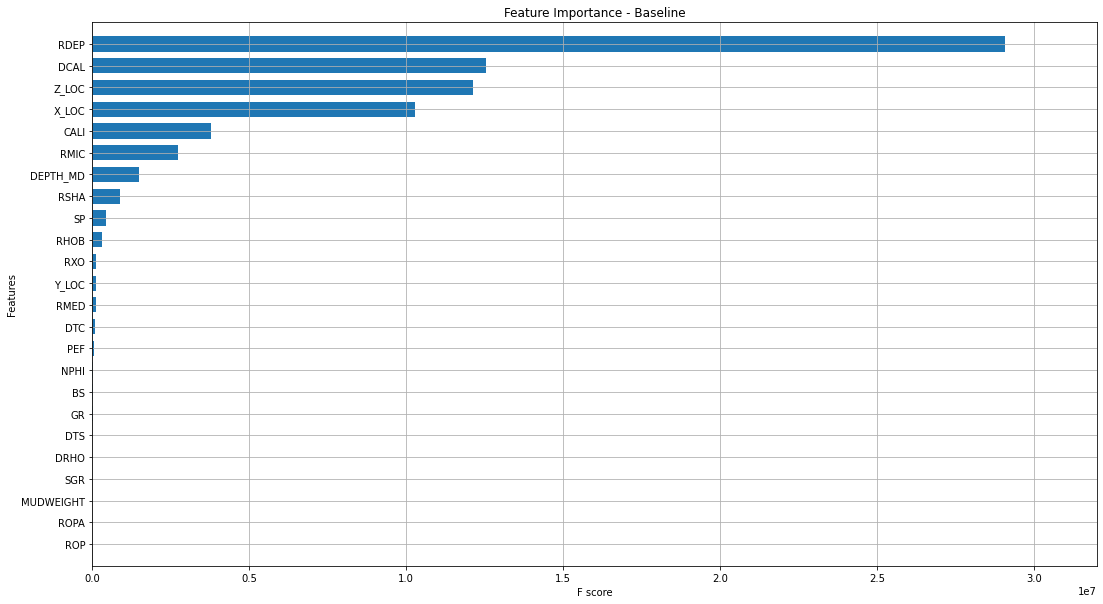

In [120]:
# Measuring the features importance
plt.rcParams['figure.figsize'] = (18, 10)
plot_importance(booster = baseline_model, height = 0.7, importance_type = 'gain', show_values = False, title = 'Feature Importance - Baseline');

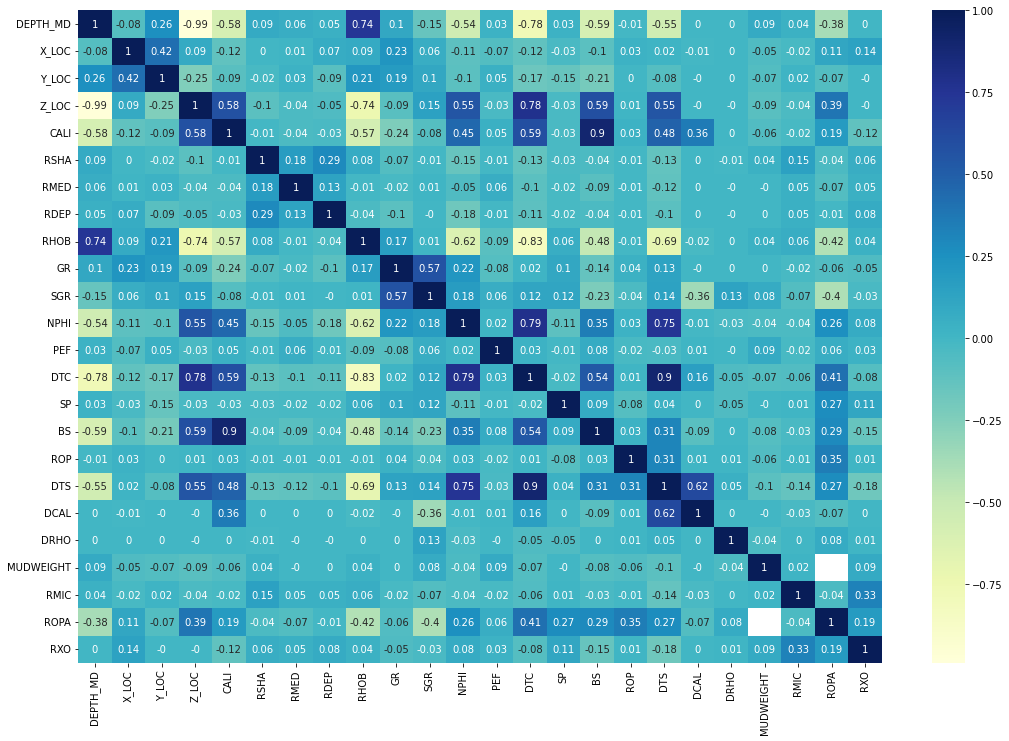

In [64]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(X_train_b.corr(),2), annot=True, cmap='YlGnBu');

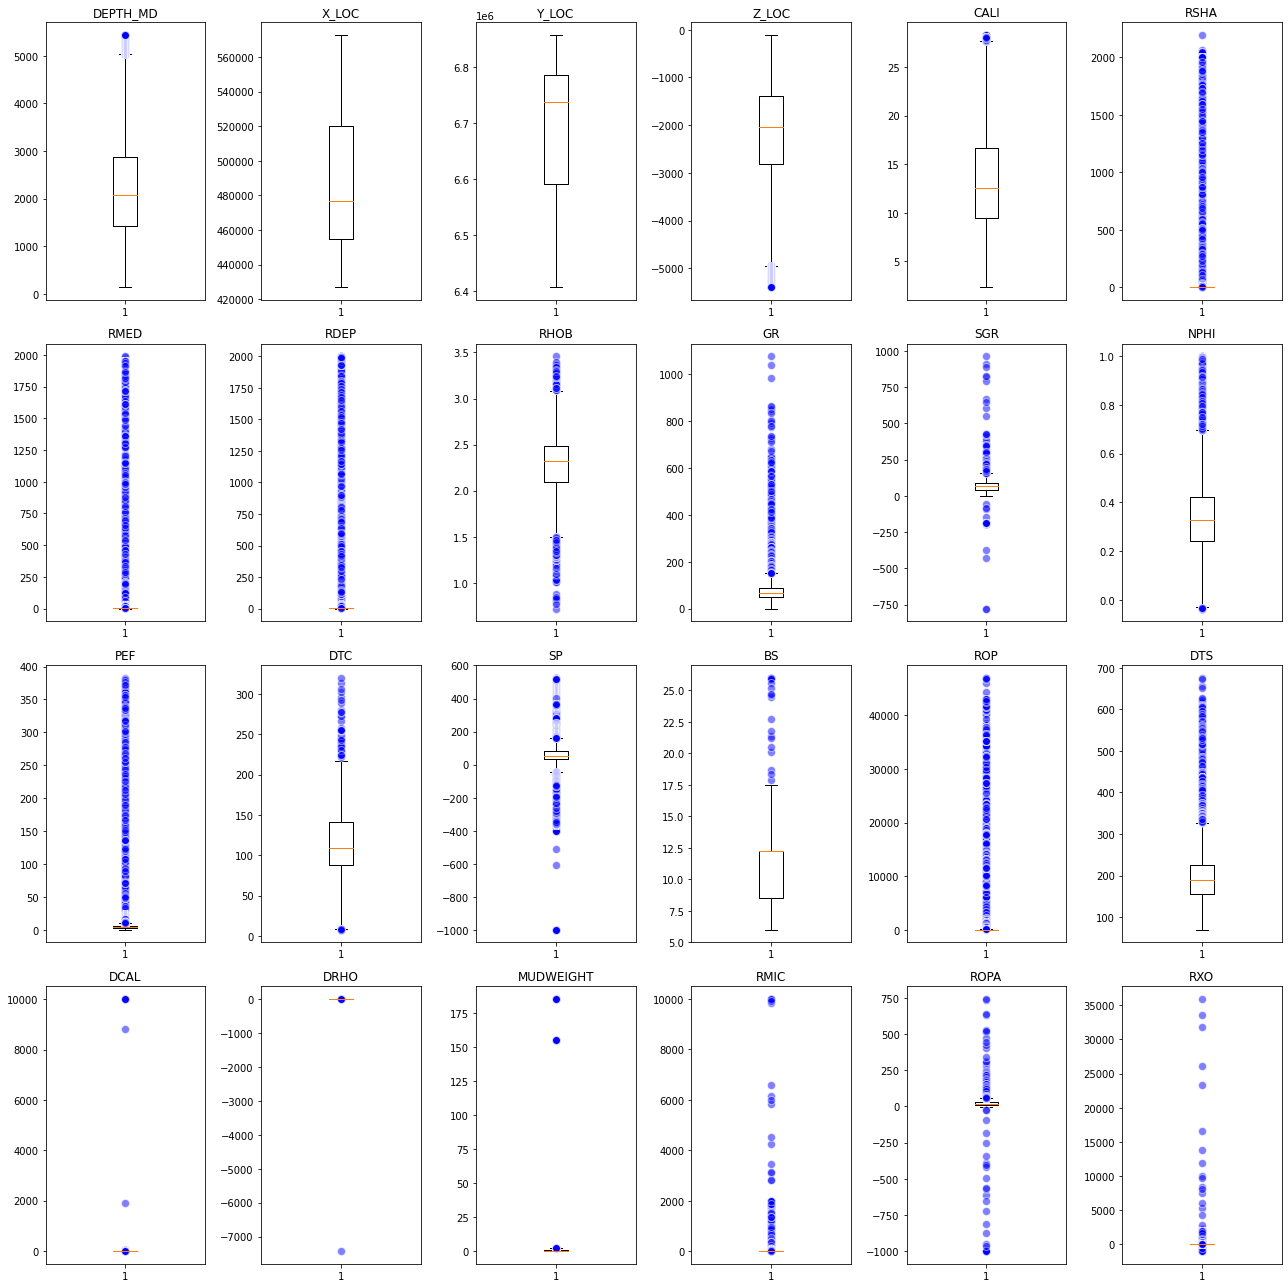

In [112]:
fig, axs = plt.subplots(4, int(len(X_train_b.columns)/4), figsize=(18, 18))
red_circle = dict(markerfacecolor='blue', marker='o', markersize=8, alpha=0.5, markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(X_train_b.iloc[:, i].dropna(), flierprops=red_circle)
    ax.set_title(X_train_b.columns[i])
    ax.tick_params(axis='x', labelsize=10)

plt.tight_layout();